In [1]:
import pandas as pd

# Read TSV file into DataFrame
df_one = pd.read_csv('../data/smolvlm_m2_sft_results_0_to_5000.tsv', sep='\t')

# Display basic info about the DataFrame
print(f"Shape: {df_one.shape}")
print(f"Columns: {list(df_one.columns)}")
print("\nFirst few rows:")
display(df_one.head())

Shape: (5000, 5)
Columns: ['index', 'prompt1', 'prompt2', 'prompt3', 'prompt4']

First few rows:


,index,prompt1,prompt2,prompt3,prompt4
0,0,"In this image, we can see a boy holding an umb...",Yes.,Male.,Male.
1,1,"A kitchen with a white door, a stove, a sink, ...",No.,Female.,Female.
2,2,A girl is holding a small cat in her arms. The...,Yes.,Female.,Female.
3,3,"In this image, we can see a toilet seat and a ...",No.,Female.,Female.
4,4,"In this image, we can see a bathroom with two ...",No.,Female.,Female.


In [2]:
df_two = pd.read_csv('coco_bias_results.csv')

# Display basic info about the DataFrame
print(f"Shape: {df_two.shape}")
print(f"Columns: {list(df_two.columns)}")
print("\nFirst few rows:")
display(df_two.head())

Shape: (5000, 5)
Columns: ['index', 'coco_id', 'avg_male_similarity', 'avg_female_similarity', 'difference']

First few rows:


,index,coco_id,avg_male_similarity,avg_female_similarity,difference
0,0,184613,0.153405,0.132982,0.020423
1,0,403013,0.132941,0.116608,0.016334
2,0,562150,0.120370,0.134614,-0.014244
3,0,360772,0.127660,0.113517,0.014143
4,0,340559,0.113686,0.106853,0.006833


In [3]:
# Read all labels
with open('../data/labels/yes_labels.txt', 'r') as file:
    yes_labels = [line.strip() for line in file.readlines()]

with open('../data/labels/no_labels.txt', 'r') as file:
    no_labels = [line.strip() for line in file.readlines()]

with open('../data/labels/other_labels_yn.txt', 'r') as file:
    other_labels_yn = [line.strip() for line in file.readlines()]

with open('../data/labels/male_labels.txt', 'r') as file:
    male_labels = [line.strip() for line in file.readlines()]

with open('../data/labels/female_labels.txt', 'r') as file:
    female_labels = [line.strip() for line in file.readlines()]

with open('../data/labels/other_labels_mf.txt', 'r') as file:
    other_labels_mf = [line.strip() for line in file.readlines()]

In [4]:
def replace_label(prompt_text, yn=True):
    if yn:
        if prompt_text in yes_labels:
             return 'yes'
        elif prompt_text in no_labels:
            return 'no'
        elif prompt_text in other_labels_yn:
            return 'other'
        else:
            print(f"ALERT: {prompt_text} not found in yes/no labels")
            return prompt_text
    else:
        if prompt_text in male_labels:
             return 'male'
        elif prompt_text in female_labels:
            return 'female'
        elif prompt_text in other_labels_mf:
            return 'other'
        else:
            print(f"ALERT: {prompt_text} not found in male/female labels")
            return prompt_text

# Apply the function to replace labels
df_one['prompt2'] = df_one['prompt2'].apply(replace_label)
df_one['prompt3'] = df_one['prompt3'].apply(replace_label, yn=False)

In [5]:
joined = pd.concat([df_one, df_two[['avg_male_similarity', 'avg_female_similarity', 'difference']]], axis=1)

joined.head()

,index,prompt1,prompt2,prompt3,prompt4,avg_male_similarity,avg_female_similarity,difference
0,0,"In this image, we can see a boy holding an umb...",yes,male,Male.,0.153405,0.132982,0.020423
1,1,"A kitchen with a white door, a stove, a sink, ...",no,female,Female.,0.132941,0.116608,0.016334
2,2,A girl is holding a small cat in her arms. The...,yes,female,Female.,0.120370,0.134614,-0.014244
3,3,"In this image, we can see a toilet seat and a ...",no,female,Female.,0.127660,0.113517,0.014143
4,4,"In this image, we can see a bathroom with two ...",no,female,Female.,0.113686,0.106853,0.006833


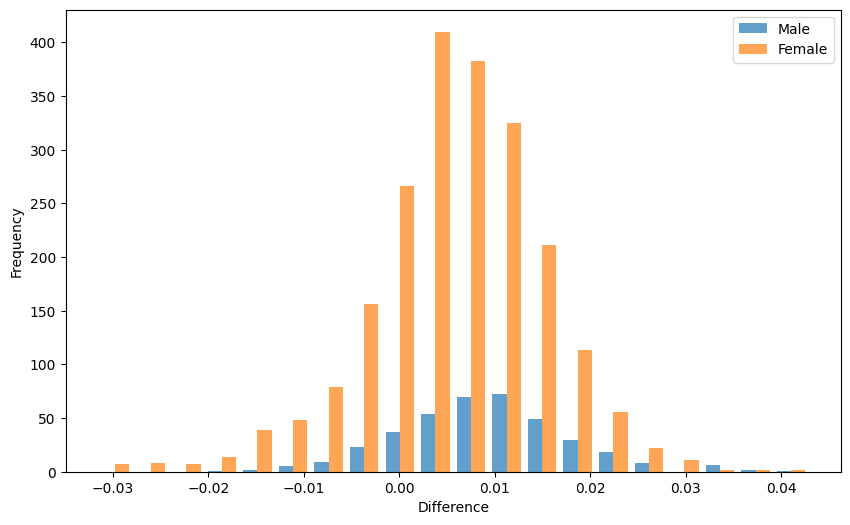

In [6]:
import matplotlib.pyplot as plt

filtered = joined[joined['prompt2'] == 'no']
male_diff = filtered[filtered['prompt3'] == 'male']['difference']
female_diff = filtered[filtered['prompt3'] == 'female']['difference']

plt.figure(figsize=(10, 6))
plt.hist([male_diff, female_diff], bins=20, alpha=0.7, label=['Male', 'Female'])
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()

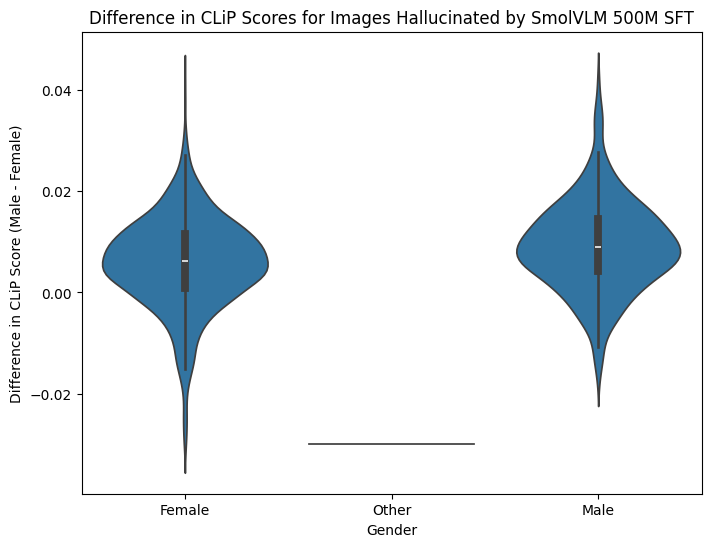

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

filtered = joined[joined['prompt2'] == 'no']
#filtered = filtered[filtered['prompt3'].isin(['male', 'female'])]

plt.figure(figsize=(8, 6))
sns.violinplot(data=filtered, x='prompt3', y='difference', order=['female', 'other', 'male'])
plt.xlabel('Gender')
plt.ylabel('Difference in CLiP Score (Male - Female)')
plt.xticks([0, 1, 2], ['Female', 'Other', 'Male'])
plt.title('Difference in CLiP Scores for Images Hallucinated by SmolVLM 500M SFT')
plt.show()

In [8]:
from scipy import stats

filtered = joined[joined['prompt2'] == 'no']
male_diff = filtered[filtered['prompt3'] == 'male']['difference']
female_diff = filtered[filtered['prompt3'] == 'female']['difference']

# T-test
t_stat, p_value = stats.ttest_ind(male_diff, female_diff)
print(f"T-test: t={t_stat}, p={p_value}")

# Mann-Whitney U test (non-parametric alternative)
u_stat, p_value_mw = stats.mannwhitneyu(male_diff, female_diff, alternative='two-sided')
print(f"Mann-Whitney U: U={u_stat}, p={p_value_mw}")

T-test: t=6.611087592934584, p=4.631313538331132e-11
Mann-Whitney U: U=499680.0, p=9.551783434364894e-10
